In [1]:
import xarray as xr
import os
import numpy as np
import fnmatch
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

In [2]:
date = "20220914"

static_features_data = "/home/jturner/false_low_clouds_2023/Static_Features/"+date

nlct_path = "/home/jturner/false_low_clouds_2023/Nighttime_Low_Cloud_Test/"

Data should come from the smiller2 source: 

In [3]:
filenames = os.listdir(static_features_data)
for filename in filenames: 
    
    #--- To avoid duplicates, loop through only Band 07 data
    if filename[0:21] == 'OR_ABI-L1b-RadF-M6C07':
        print(filename)

OR_ABI-L1b-RadF-M6C07_G16_s20222570020204_e20222570029523_c20222570029566.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570140204_e20222570149523_c20222570149565.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570240204_e20222570249524_c20222570249569.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570200204_e20222570209524_c20222570209566.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570340204_e20222570349523_c20222570349566.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570030204_e20222570039524_c20222570039566.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570110204_e20222570119524_c20222570119568.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570210204_e20222570219523_c20222570219565.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570310204_e20222570319524_c20222570319568.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570330204_e20222570339523_c20222570339569.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570000204_e20222570009524_c20222570009562.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570010204_e20222570019524_c20222570019569.nc
OR_ABI-L1b-RadF-M6C07_G16_s20222570150204_e20222570159523_c20222570159564.nc

In [4]:
filename = 'OR_ABI-L1b-RadF-M6C07_G16_s20222570020204_e20222570029523_c20222570029566.nc'

In [5]:
#--- Using full extent of GOES East

min_lon = -180
min_lat = -90
max_lon = 0
max_lat = 90

lats = (min_lat, max_lat)
lons = (min_lon, max_lon)

In [6]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    # Added absolute to remove error
    r_s = (-b - np.sqrt(np.absolute(b**2 - 4*a*c)))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds



def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))


In [7]:
def create_BTD(static_features_data, filename):

    data_07 = xr.open_dataset(static_features_data+'/'+filename)
    
    year = filename[27:31]
    jul_day = filename[31:34]
    h = filename[34:36]
    m = filename[36:38]

    print('Processing 07 band for '+year+'-'+jul_day+' '+h+':'+m)

    ds_07 = calc_latlon(data_07)

    ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_07, lats, lons)

    subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))

    #--- Search for corresponding Band 14 file:
    files = os.listdir(static_features_data) 
    pattern = 'OR_ABI-L1b-RadF-M6C14*'+filename[27:38]+'*.nc'
    filename_14 = str(fnmatch.filter(files, pattern)[0])

    data_14 = xr.open_dataset(static_features_data+'/'+filename_14)

    print('Processing 14 band for '+year+'-'+jul_day+' '+h+':'+m)

    ds_14 = calc_latlon(data_14)

    ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_14, lats, lons)

    subset_14 = ds_14.sel(x=slice(x1, x2), y=slice(y2, y1))

    #--- Calculate BTD and take product of the data over time
    T_07 = (subset_07.planck_fk2/(np.log((subset_07.planck_fk1/subset_07.Rad)+1)) - subset_07.planck_bc1)/subset_07.planck_bc2
    T_14 = (subset_14.planck_fk2/(np.log((subset_14.planck_fk1/subset_14.Rad)+1)) - subset_14.planck_bc1)/subset_14.planck_bc2

    BTD = T_14 - T_07
    
    yr_m_d = datetime.datetime.strptime(year+jul_day, '%Y%j').date()
    time_delta = datetime.timedelta(hours=int(h), minutes=int(m))
    dt = datetime.datetime.combine(yr_m_d, datetime.datetime.min.time()) + time_delta
    BTD = BTD.expand_dims({'time':[dt]})
    
    return BTD

In [8]:
BTD = create_BTD(static_features_data, filename)

Processing 07 band for 2022-257 00:20
Processing 14 band for 2022-257 00:20


/home/jturner/miniconda3/lib/python3.9/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [9]:
BTD

<xarray.DataArray (time: 1, y: 5424, x: 5424)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2022-09-14T00:20:00
    y_image  float32 0.0
    x_image  float32 0.0
  * y        (y) float32 0.151844 0.151788 0.151732 ... -0.151788 -0.151844
  * x        (x) float32 -0.151844 -0.151788 -0.151732 ... 0.151788 0.151844
    lat      (y, x) float32 28.518614 28.528791 ... -28.528791 -28.518614
    lon      (y, x) float32 -108.09449 -108.09631 ... -41.903687 -41.90551

In [10]:
#--- Creating the datetime string

dt = BTD.time[0].values.astype(datetime.datetime)
python_dt = datetime.datetime.utcfromtimestamp(dt * 1e-9)
dt_str = python_dt.strftime("%Y_%m_%d_%HH_%MM")
dt_str

'2022_09_14_00H_20M'

In [11]:
#--- Saving the file in /Nighttime_Low_Cloud_Test

file = open(nlct_path+"goes_e_ntlc_"+dt_str, 'wb')
BTD_file = pickle.dump(BTD, file)
file.close()

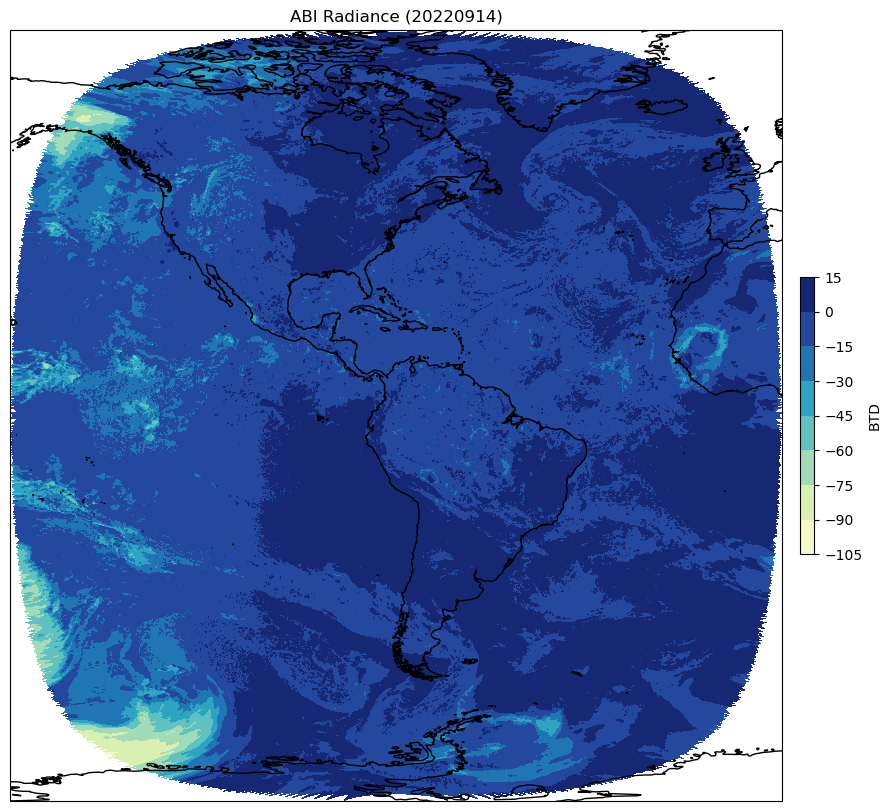

In [12]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu

c=ax.contourf(BTD.lon, BTD.lat, BTD[0], cmap=cmap, extend='neither')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI Radiance ('+date+')')
clb.set_label('BTD')

#ax.add_feature(cfeature.STATES)
ax.coastlines(resolution='50m', color='black', linewidth=1)